# Description of file:

This file aims to calculate the fractal dimension, and form the box count diagrams of our algorithm. We then find the translations of the image which minimises the box counts of the fractal dimension finding algorithm. This optimal translation was visualised using the aforementioned box count diagrams.

## Functions:

### `fractal_dimension(Z, threshold = 0.9)`:
This uses two arguments: `Z` = one of the normalised image, and `threshold` = the threhsold value for conversion from pixel intensities to binary arrays. This returns the coefficient of the graph in of Minkowski-Bouligand graph and `x` and `y` values (which are the log(s) and log(N(s)) from:

$$\ln[N(s)] = \textrm{ - Dimension}\: * \: \ln(s) + h(s) $$

This function also provides the indices of the boxes used to cover the fractal figure, used in `troubleshoot()` method to visualise algorithm.

### `translate(file_name, lr, ud)`:
Uses the `cv2.warpAffine()` to translate image, where `lr` and `ud`, represent the horizontal and vertical displacement respectively. The file labeled `file_name` is translated and the resultant image is saved using `filename`+`lr`+`ud`. 

### `troubleshoot(im, sizes, counts, co_ords)`:
Used to visualise the "Hit" boxes and the "background" boxes, for a series of box sizes, indices provided by the `fractal_dimension()` method.

Takes arguments `im` = image under investigation, `sizes` = is a ordered list of box sizes, `counts` = is a ordered list of counts, ordered with respect to the `sizes` list. `co_ords` = list that provides co-ordinates of the "Hit" boxes, hence is used to highlight such boxes in the visualisation algorithm.

### `box_counts(Z, threshold=0.9)`:
Similar to the `fractal_dimension()` method, although without the calculation of the `x` and `y`. Here only box counts and box size lists are returned. This function is used inorder to find the average minimum box coverings, hence to find the translations which were optimum.


### `multi_translations(image, x, y)`:  
Automate the translation of the images used in this project, and the use of the `box_counts()` method.

In [105]:
import scipy.misc
import numpy as np
from sklearn.linear_model import LinearRegression
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot, transforms
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = [40, 40]
import math

In [106]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]

In [107]:
def troubleshoot(im, sizes, counts, co_ords):
    
    #  below is the logic to iterate through subplots
    rows = len(sizes)//4
    if len(sizes) % 4 != 0:
        rows +=1
        
    fig, ax = plt.subplots(rows,4)
    co_ords_count = -1
    row_count = 0
    
    
    # iterate through list of box sizes
    for i in range(len(sizes)):
        
        # more logic to display results in the correct subplot in grid.
        co_ords_count += 1
        if i % 4 == 0 and i != 0:
            row_count += 1
        column_count = i - (row_count* 4)
        
        # form the numpy array starting from 0 iterated by the given box size. i.e. box size indices referrenced
        # in chapter 2 of the dissertation
        num_line = list(np.arange(0, max(im.shape), sizes[i]))
        

        for idx_x in range(len(num_line)):
            
            # to prevent the visualisation of box sizes < 5, to reduce time complexity of algorithm
            if sizes[i] < 5:
                break
                
            # iterate through numpy array formed previously
            for idx_y in range(len(num_line)):
                
            # if the index of box is in list of "Hit" boxes then form coloured patch at location (idx_x, idx_y)
            # patch is coloured green
                if (idx_y, idx_x) in co_ords[co_ords_count]:
                    rect = patches.Rectangle((num_line[idx_x], num_line[idx_y]), sizes[i], sizes[i], linewidth=1, edgecolor='r', facecolor='g', alpha = 0.35)
                    
            # otherwise form patch with no colour
                else:
        
                    rect = patches.Rectangle((num_line[idx_x], num_line[idx_y]), sizes[i], sizes[i], linewidth=1, edgecolor='r', facecolor='none')
                ax[row_count,column_count].add_patch(rect)
            
        # show plots
        ax[row_count,column_count].imshow(im)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);


In [108]:
def fractal_dimension(Z, threshold=0.9):
    

    # Only for 2d image
    assert(len(Z.shape) == 2)

    
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z <= threshold)

    # Minimal dimension of image
    p = min(Z.shape)
    
    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
    sizes = sizes[1:]
    
    print(sizes)
    # Actual box counting with decreasing size
    counts = []
    
    # co_ords is a list of indices, indicating the boxes used to cover the fractal
    co_ords = []
    for size in sizes:
        counts.append(boxcount(Z, size)[0])
        co_ordinates = boxcount(Z, size)[1]
        co_ords.append([(co_ordinates[0][i],co_ordinates[1][i]) for i in range(len(co_ordinates[0]))])
    
    

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    x = np.log(sizes)
    y = np.log(counts)
    troubleshoot(Z, sizes, counts, co_ords)
    
    return -coeffs[0], x, y , co_ords




In [109]:
def start(filename, pixel_threshold = 0.9):
    I = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    I = I/256
    coeff, x, y, co_ords  = fractal_dimension(I, pixel_threshold)
    print("Minkowski–Bouligand dimension (computed): ", coeff)
    return coeff, x, y, co_ords

#### Below is an image representation of the box counting algorithm used in chapter 2

shape of image : (463, 615)
[128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.2282242668723684


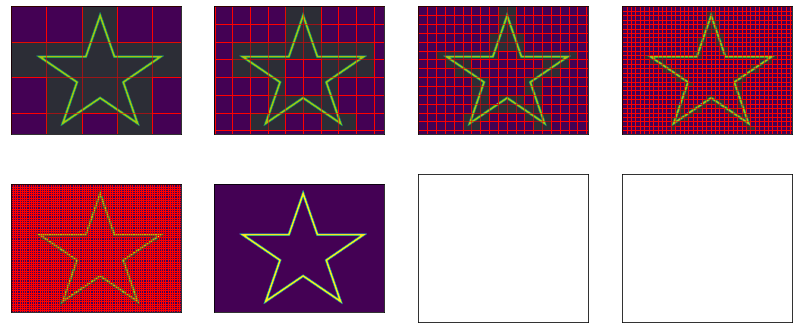

In [138]:
coeff, x, y, co_ords = start("./star.png")

### Transalting image and saving it to the directory.

In [139]:
def translate(file_name, lr, ud):
    ROOT = "./SelfSimilarFractals/"
    
    file_dir = ROOT + file_name
    
    img = cv2.imread(file_dir)
    num_rows, num_cols = img.shape[:2]
    
    # implements the translation seen in the disseration
    translation_matrix = np.float32([ [1,0,lr], [0,1,ud] ])
    img_translation = cv2.warpAffine(img, translation_matrix, (num_cols, num_rows), borderValue=(255,255,255))
    
    new_path = ROOT + "translated/"+file_name[:-4]+ str(int(lr)) + "+" + str(int(ud)) + file_name[-4:]
    
    # saves the translated image using the new filename string
    cv2.imwrite(new_path, img_translation)
    return new_path
    
    

In [145]:
def box_counts(Z, threshold=0.9):
    Z = cv2.imread(Z, cv2.IMREAD_GRAYSCALE)
    
    Z = Z/256
    assert(len(Z.shape) == 2)

    
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        return len(np.where((S > 0) & (S < k*k))[0])

    Z = (Z <= threshold)

    p = min(Z.shape)

    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))

    sizes = 2**np.arange(n, 1, -1)
    sizes = list(sizes)
    sizes = sizes[1:]
    counts = []
    sizes = np.array(sizes)
    
    for size in sizes:
        counts.append(boxcount(Z, size))

    return sizes, counts

In [146]:
def multi_translations(image, x, y):
    # calls the translate() method
    new_path = translate(image, x, y)
    
    # calls the box_counts() method on the newly saved file from the previous step
    sizes, counts = box_counts(new_path)
    return sizes, counts

#### The below code forms the translation axis (figure 3.3 in dissertation)
Places these transaltion in two global lists, `x` and `y`, representing the horizontal and verticle displacement

In [147]:
files = [ "GreatBritain.png",  "SierpinskiTriangleHD.png", "Douady_rabbitNew.png",  "JuliaSetNew.png", "irelandcoastNew.png"]
x= [0,1, -1 ,1 , -1, 1, 0,-1,0]
y = [0,1 ,-1 ,-1, 1, 0, 1, 0,-1]

x = list(np.array(x)*10)
x = x +list(np.array(x)*2)  + list(np.array(x)*3) + list(np.array(x)*4) + list(np.array(x)*5) + list(np.array(x)*10) #+ list(np.array(x)*15) #+ list(np.array(x)*20)  
y = list(np.array(y)*10)
y = y +list(np.array(y)*2) + list(np.array(y)*3) + list(np.array(y)*4) + list(np.array(y)*5) + list(np.array(y)*10) #+ list(np.array(y)*15) #+ list(np.array(x)*20)   

### The below code implements the translations formed in the previous cell
Using the `multi_translate()` method. We average the box counts and save the results in the dictionary `res`.

In [148]:
s = {file : {} for file in files}   
res= {file : {} for file in files}   

for file in files:
    for idx in range(len(x)):
        s[file][(x[idx], y[idx])]   = (multi_translations(file, x[idx], y[idx]))
        
        curr_count_lst = s[file][(x[idx], y[idx])][1]
        curr_count_mean = sum(curr_count_lst)/len(curr_count_lst)
        res[file][(x[idx], y[idx])] = curr_count_mean


### The below code searches the `res` dictionary for the minimum average box counts. 
Saving the translation at which this lowest box count occurs in dicitonary `mini_trans`

In [149]:
min_trans = {}

for fractal in res.keys():
    min_trans[fractal] = min(res[fractal], key=res[fractal].get)

min_trans

{'GreatBritain.png': (20, -20),
 'SierpinskiTriangleHD.png': (50, 0),
 'Douady_rabbitNew.png': (-50, -50),
 'JuliaSetNew.png': (0, -20),
 'irelandcoastNew.png': (0, 30)}

# Below we represent the box count diagrams for the five benchmark fractals. Depicting the original fractal, alongside the optimally translated fractal.

# coast of Great britain

###  coast of Great Britain fractal dimension of original image

shape of image : (632, 632)
[256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.207610597478608


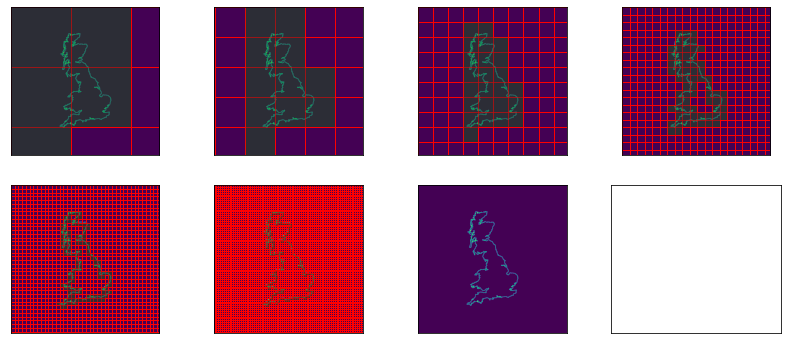

In [94]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/greatbritain.png")

###  coast of Great Britain fractal dimension of optimally translated image

shape of image : (632, 632)
[256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.246101713526778


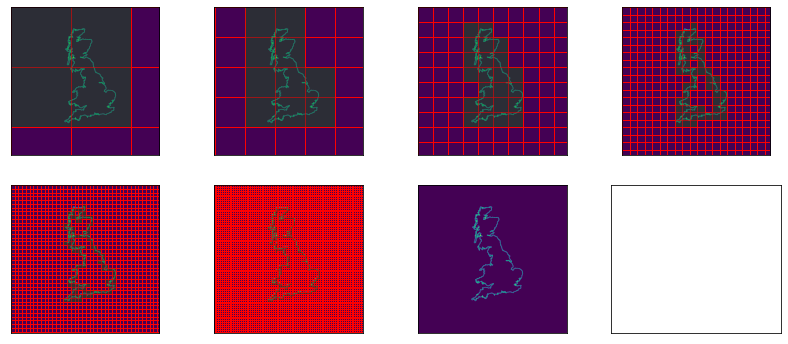

In [92]:
coeff, x, y , co_ords= start("./SelfSimilarFractals/translated/GreatBritain20+-20.png")

# Sierpinski triangle

### Sierpinski triangle fractal dimension of original image

shape of image : (1400, 1800)
[512, 256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.4669184976174214


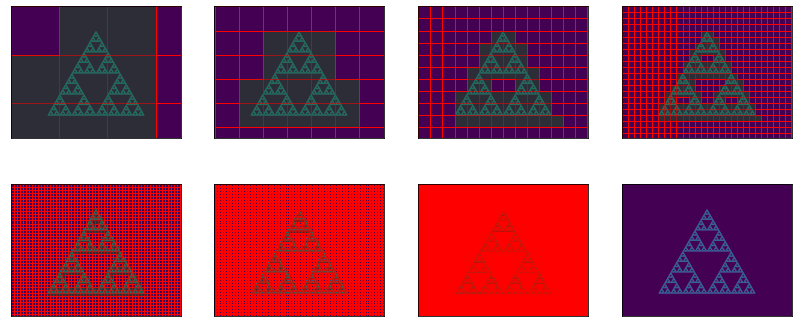

In [95]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/SierpinskiTriangleHD.png")

### Sierpinski triangle fractal dimension of optimally translated image

shape of image : (1400, 1800)
[512, 256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.490129363355713


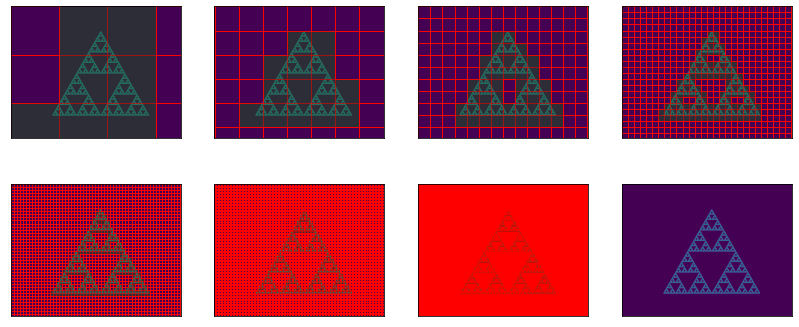

In [93]:
coeff, x, y , co_ord = start("./SelfSimilarFractals/translated/SierpinskiTriangleHD50+0.png".format())

# Julia set

### Julia set fractal dimension of original image

shape of image : (1000, 1600)
[256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.2569918243157967


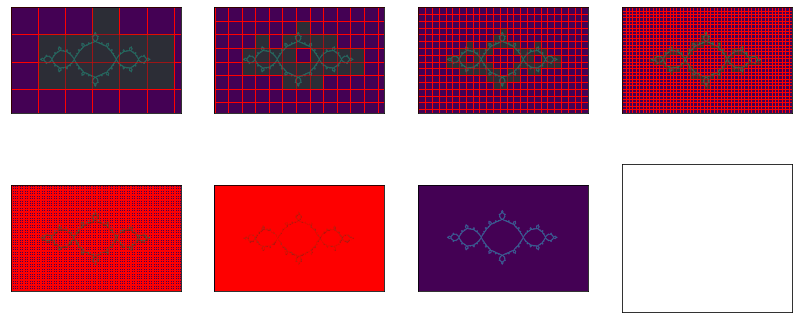

In [97]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/JuliaSetNew.png")

### Julia set fractal dimension of optimally translated image

shape of image : (1000, 1600)
[256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.2850106586699357


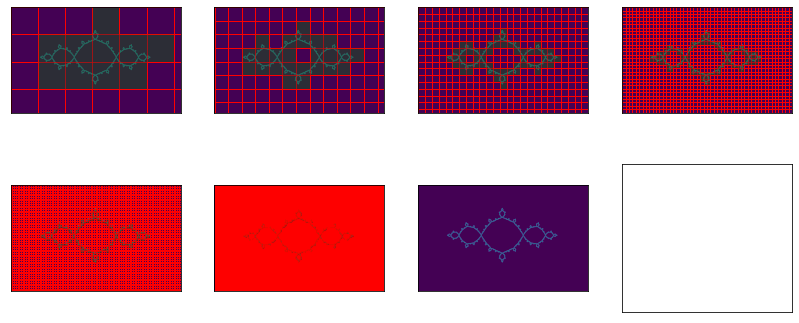

In [98]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/translated/JuliaSetNew0+-20.png")

# Douady rabbit

### Douady rabbit fractal dimension of original image

shape of image : (1500, 1500)
[512, 256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.292321749423826


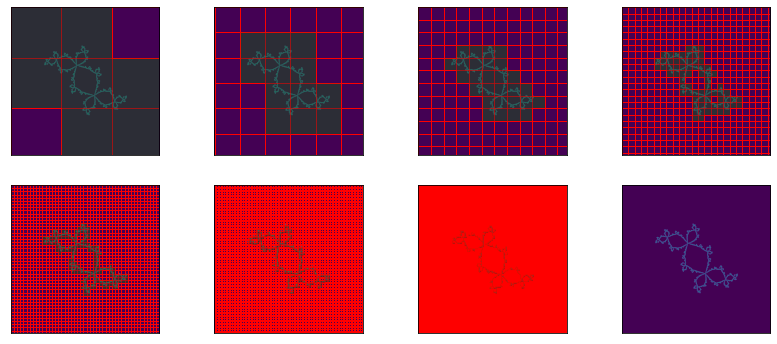

In [99]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/Douady_rabbitNew.png")

### Douady rabbit fractal dimension of optimally translated image

shape of image : (1500, 1500)
[512, 256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.3438738520927542


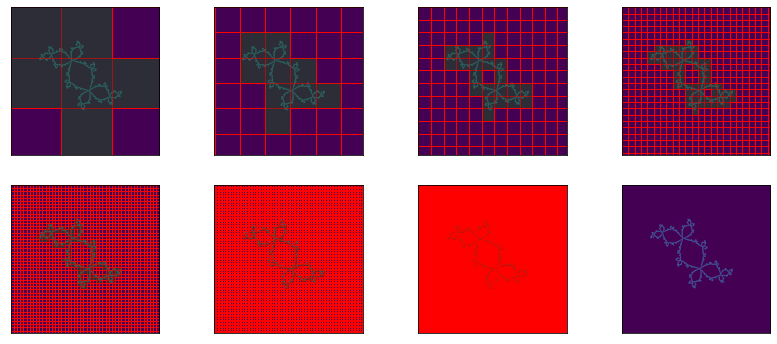

In [100]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/translated/Douady_rabbitNew-50+-50.png")

# coast of Ireland

### coast of Ireland fractal dimension of original image

shape of image : (3000, 2200)
[1024, 512, 256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.310716493978567


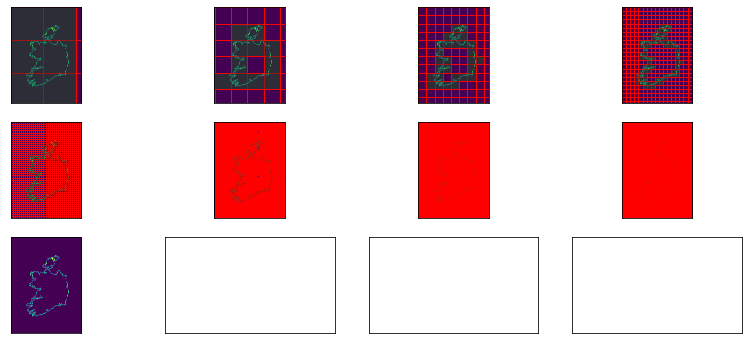

In [134]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/translated/irelandcoastNew30+30.png")

### coast of Ireland fractal dimension of optimally translated image

shape of image : (3000, 2200)
[1024, 512, 256, 128, 64, 32, 16, 8, 4]
Minkowski–Bouligand dimension (computed):  1.3012356218512242


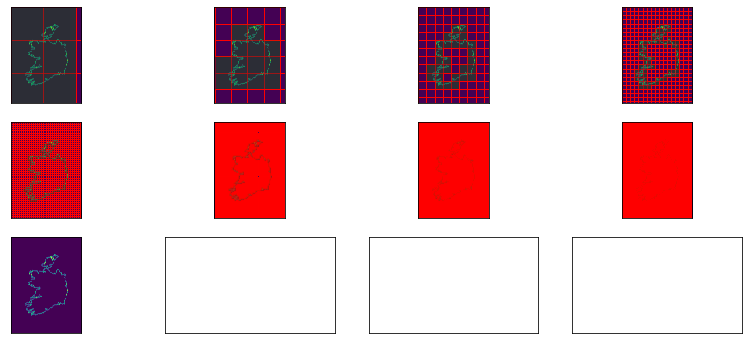

In [135]:
coeff, x, y, co_ords = start("./SelfSimilarFractals/irelandcoastNew.png")